# Prediction of Time to Failure (Remaining Useful Life)

In this notebook, we predict the remaining useful life (=Time to Failure = TTF) of 100 different engines based on training data consisting of operational settings, sensor measurements and the cycle numbers of engine breakdowns. The sources are taken from: https://github.com/Polanitz/Regression

In [397]:
#import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline 
np.random.seed(1337)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor

# Data Preprocessing

## Loading datasets 

In [398]:
#loading datasets
df_train = pd.read_csv('Train_dataset.csv', parse_dates=False, delimiter=" ", decimal=".", header=None)
df_test = pd.read_csv('Test_dataset.csv', parse_dates=False, delimiter=" ", decimal=".", header=None)
TrueTTF = pd.read_csv('TTF_dataset.csv', parse_dates=False, delimiter=" ", decimal=".", header=None)

In [399]:
# adding column names
headers=["unit (engine) number","time in cycles","operational setting 1","operational setting 2",\
         "operational setting 3","Total temperature at fan inlet","Total temperature at LPC outlet",\
         "Total temperature at HPC outlet","Total temperature at LPT outlet","Pressure at fan inlet",\
         "Total pressure in bypass-duct","Total pressure at HPC outlet","Physical fan speed",\
         "Physical core speed","Engine pressure ratio (P50/P2)","Static pressure at HPC outlet",\
         "Ratio of fuel flow to Ps30","Corrected fan speed","Corrected core speed","Bypass Ratio","Burner fuel-air ratio",\
         "Bleed Enthalp","Demanded fan speed","Demanded corrected fan speed","HPT coolant bleed","LPT coolant bleed","sen22","sen23"]
df_train.columns=headers
df_test.columns=headers
TrueTTF.columns= ['TTF']

In [400]:
df_train.shape

(20631, 28)

In [401]:
df_train.head()

,unit (engine) number,time in cycles,operational setting 1,operational setting 2,operational setting 3,Total temperature at fan inlet,Total temperature at LPC outlet,Total temperature at HPC outlet,Total temperature at LPT outlet,Pressure at fan inlet,...,Corrected core speed,Bypass Ratio,Burner fuel-air ratio,Bleed Enthalp,Demanded fan speed,Demanded corrected fan speed,HPT coolant bleed,LPT coolant bleed,sen22,sen23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [403]:
# The training datasets contains the number maximum number of cycles for each engine and goes on with the measurements for
# the next engine afterwards. For example, engine 1 worked for 192 cycles until it broke down.
df_train.iloc[190:200,:]

,unit (engine) number,time in cycles,operational setting 1,operational setting 2,operational setting 3,Total temperature at fan inlet,Total temperature at LPC outlet,Total temperature at HPC outlet,Total temperature at LPT outlet,Pressure at fan inlet,...,Corrected core speed,Bypass Ratio,Burner fuel-air ratio,Bleed Enthalp,Demanded fan speed,Demanded corrected fan speed,HPT coolant bleed,LPT coolant bleed,sen22,sen23
190,1,191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36,1425.77,14.62,...,8114.61,8.5174,0.03,394,2388,100.0,38.45,23.1295,NaN,NaN
191,1,192,0.0009,-0.0000,100.0,518.67,643.54,1601.41,1427.20,14.62,...,8110.93,8.5113,0.03,396,2388,100.0,38.48,22.9649,NaN,NaN
192,2,1,-0.0018,0.0006,100.0,518.67,641.89,1583.84,1391.28,14.62,...,8137.72,8.3905,0.03,391,2388,100.0,38.94,23.4585,NaN,NaN
193,2,2,0.0043,-0.0003,100.0,518.67,641.82,1587.05,1393.13,14.62,...,8131.09,8.4167,0.03,392,2388,100.0,39.06,23.4085,NaN,NaN
194,2,3,0.0018,0.0003,100.0,518.67,641.55,1588.32,1398.96,14.62,...,8140.58,8.3802,0.03,391,2388,100.0,39.11,23.4250,NaN,NaN
195,2,4,0.0035,-0.0004,100.0,518.67,641.68,1584.15,1396.08,14.62,...,8140.44,8.4018,0.03,391,2388,100.0,39.13,23.5027,NaN,NaN
196,2,5,0.0005,0.0004,100.0,518.67,641.73,1579.03,1402.52,14.62,...,8136.67,8.3867,0.03,390,2388,100.0,39.18,23.4234,NaN,NaN
197,2,6,-0.0010,0.0004,100.0,518.67,641.30,1577.50,1396.76,14.62,...,8133.65,8.3800,0.03,392,2388,100.0,39.15,23.4270,NaN,NaN
198,2,7,0.0001,-0.0002,100.0,518.67,642.03,1587.49,1400.65,14.62,...,8136.33,8.3941,0.03,391,2388,100.0,39.10,23.4718,NaN,NaN
199,2,8,0.0015,-0.0004,100.0,518.67,642.55,1590.41,1395.39,14.62,...,8137.92,8.3861,0.03,391,2388,100.0,39.11,23.4381,NaN,NaN


In [404]:
df_test.shape

(13096, 28)

In [405]:
df_test.head()

,unit (engine) number,time in cycles,operational setting 1,operational setting 2,operational setting 3,Total temperature at fan inlet,Total temperature at LPC outlet,Total temperature at HPC outlet,Total temperature at LPT outlet,Pressure at fan inlet,...,Corrected core speed,Bypass Ratio,Burner fuel-air ratio,Bleed Enthalp,Demanded fan speed,Demanded corrected fan speed,HPT coolant bleed,LPT coolant bleed,sen22,sen23
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN


In [406]:
# The test set contains measurements of the same 100 engines but not measurements until the breakdown. For example, the test
# dataset contains measurements for 31 cycles of engine 1. Now the goal is to predict the remaining useful life until the next
# breakdown would occur.
df_test.iloc[28:50,:]

,unit (engine) number,time in cycles,operational setting 1,operational setting 2,operational setting 3,Total temperature at fan inlet,Total temperature at LPC outlet,Total temperature at HPC outlet,Total temperature at LPT outlet,Pressure at fan inlet,...,Corrected core speed,Bypass Ratio,Burner fuel-air ratio,Bleed Enthalp,Demanded fan speed,Demanded corrected fan speed,HPT coolant bleed,LPT coolant bleed,sen22,sen23
28,1,29,0.0014,0.0001,100.0,518.67,641.95,1587.15,1398.11,14.62,...,8133.13,8.4212,0.03,392,2388,100.0,39.02,23.3621,NaN,NaN
29,1,30,-0.0025,0.0004,100.0,518.67,642.79,1585.72,1400.97,14.62,...,8134.79,8.4110,0.03,391,2388,100.0,39.09,23.4069,NaN,NaN
30,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,...,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552,NaN,NaN
31,2,1,-0.0009,0.0004,100.0,518.67,642.66,1589.30,1407.16,14.62,...,8129.59,8.4283,0.03,392,2388,100.0,39.00,23.3923,NaN,NaN
32,2,2,-0.0011,0.0002,100.0,518.67,642.51,1588.43,1405.47,14.62,...,8120.05,8.4414,0.03,393,2388,100.0,38.84,23.2902,NaN,NaN
33,2,3,0.0002,0.0003,100.0,518.67,642.58,1595.60,1410.86,14.62,...,8126.75,8.3804,0.03,394,2388,100.0,39.02,23.4064,NaN,NaN
34,2,4,0.0025,0.0001,100.0,518.67,642.31,1583.43,1408.23,14.62,...,8129.91,8.4342,0.03,393,2388,100.0,38.82,23.4699,NaN,NaN
35,2,5,0.0004,-0.0004,100.0,518.67,642.77,1585.03,1407.60,14.62,...,8127.01,8.4247,0.03,392,2388,100.0,38.81,23.3895,NaN,NaN
36,2,6,-0.0008,-0.0003,100.0,518.67,642.50,1579.87,1402.27,14.62,...,8128.82,8.4182,0.03,392,2388,100.0,38.78,23.2688,NaN,NaN
37,2,7,0.0019,0.0000,100.0,518.67,642.63,1594.28,1405.38,14.62,...,8127.07,8.4113,0.03,393,2388,100.0,38.75,23.5222,NaN,NaN


In [407]:
TrueTTF.shape

(100, 1)

In [409]:
# TrueTTF contains the correct number of cycles until the next breakdown would occur. For example, the goal for engine 1 is
# to predict that at the current time point (measurement cycle 31), the correct remaining useful life (=TTF) of this engine is
# 112 cycles.
TrueTTF.head()

,TTF
0,112
1,98
2,69
3,82
4,91


## Remove missing values

In [410]:
df_train.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
unit (engine) number,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
time in cycles,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
operational setting 1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
operational setting 2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
operational setting 3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
Total temperature at fan inlet,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
Total temperature at LPC outlet,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
Total temperature at HPC outlet,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
Total temperature at LPT outlet,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
Pressure at fan inlet,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


In [411]:
df_test.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
unit (engine) number,13096.0,51.543907,2.828942e+01,1.0000,28.0000,52.0000,76.0000,100.0000
time in cycles,13096.0,76.836515,5.305775e+01,1.0000,33.0000,69.0000,113.0000,303.0000
operational setting 1,13096.0,-0.000011,2.202685e-03,-0.0082,-0.0015,0.0000,0.0015,0.0078
operational setting 2,13096.0,0.000004,2.940306e-04,-0.0006,-0.0002,0.0000,0.0003,0.0007
operational setting 3,13096.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
Total temperature at fan inlet,13096.0,518.670000,6.014263e-11,518.6700,518.6700,518.6700,518.6700,518.6700
Total temperature at LPC outlet,13096.0,642.475088,4.008993e-01,641.1300,642.1975,642.4600,642.7400,644.3000
Total temperature at HPC outlet,13096.0,1588.099204,5.003274e+00,1569.0400,1584.6000,1587.9900,1591.3625,1607.5500
Total temperature at LPT outlet,13096.0,1404.735362,6.688309e+00,1384.3900,1399.9500,1404.4400,1409.0500,1433.3600
Pressure at fan inlet,13096.0,14.620000,2.671743e-12,14.6200,14.6200,14.6200,14.6200,14.6200


In [412]:
df_train.isnull().sum(axis=0)

unit (engine) number                   0
time in cycles                         0
operational setting 1                  0
operational setting 2                  0
operational setting 3                  0
Total temperature at fan inlet         0
Total temperature at LPC outlet        0
Total temperature at HPC outlet        0
Total temperature at LPT outlet        0
Pressure at fan inlet                  0
Total pressure in bypass-duct          0
Total pressure at HPC outlet           0
Physical fan speed                     0
Physical core speed                    0
Engine pressure ratio (P50/P2)         0
Static pressure at HPC outlet          0
Ratio of fuel flow to Ps30             0
Corrected fan speed                    0
Corrected core speed                   0
Bypass Ratio                           0
Burner fuel-air ratio                  0
Bleed Enthalp                          0
Demanded fan speed                     0
Demanded corrected fan speed           0
HPT coolant blee

In [413]:
df_train.shape

(20631, 28)

In [414]:
df_test.shape

(13096, 28)

In [415]:
df_train.drop(['sen22','sen23'],axis = 1, inplace=True)
df_test.drop(['sen22','sen23'],axis = 1, inplace=True)

In [416]:
df_train.shape

(20631, 26)

In [417]:
df_test.shape

(13096, 26)

## Remove flat lines

In [418]:
P = df_train.describe().T
P

,count,mean,std,min,25%,50%,75%,max
unit (engine) number,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
time in cycles,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
operational setting 1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
operational setting 2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
operational setting 3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
Total temperature at fan inlet,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
Total temperature at LPC outlet,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
Total temperature at HPC outlet,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
Total temperature at LPT outlet,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
Pressure at fan inlet,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


In [419]:
# find columns for which the 25-, 50- and 75-percentiles are equal. This means that the 
#cols = []
#for i in range(0,len(P)):
#    if P.iloc[i,4] == P.iloc[i,5] == P.iloc[i,6]:
#        cols.append(P.iloc[i].name)
#cols

In [420]:
# find columns for which min = max (flat lines)
cols = []
for i in range(0,len(P)):
    if P.iloc[i,3] == P.iloc[i,7]:
        cols.append(P.iloc[i].name)
cols

['operational setting 3',
 'Total temperature at fan inlet',
 'Pressure at fan inlet',
 'Engine pressure ratio (P50/P2)',
 'Burner fuel-air ratio',
 'Demanded fan speed',
 'Demanded corrected fan speed']

In [421]:
df_train.drop(cols,axis = 1, inplace=True)
df_test.drop(cols,axis = 1, inplace=True)

In [422]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
unit (engine) number,20631.0,51.506568,29.227633,1.0000,26.0000,52.0000,77.0000,100.0000
time in cycles,20631.0,108.807862,68.880990,1.0000,52.0000,104.0000,156.0000,362.0000
operational setting 1,20631.0,-0.000009,0.002187,-0.0087,-0.0015,0.0000,0.0015,0.0087
operational setting 2,20631.0,0.000002,0.000293,-0.0006,-0.0002,0.0000,0.0003,0.0006
Total temperature at LPC outlet,20631.0,642.680934,0.500053,641.2100,642.3250,642.6400,643.0000,644.5300
Total temperature at HPC outlet,20631.0,1590.523119,6.131150,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
Total temperature at LPT outlet,20631.0,1408.933782,9.000605,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
Total pressure in bypass-duct,20631.0,21.609803,0.001389,21.6000,21.6100,21.6100,21.6100,21.6100
Total pressure at HPC outlet,20631.0,553.367711,0.885092,549.8500,552.8100,553.4400,554.0100,556.0600
Physical fan speed,20631.0,2388.096652,0.070985,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600


In [423]:
df_train.shape

(20631, 19)

In [424]:
df_test.shape

(13096, 19)

## Visualize the distributions of all remaining features 

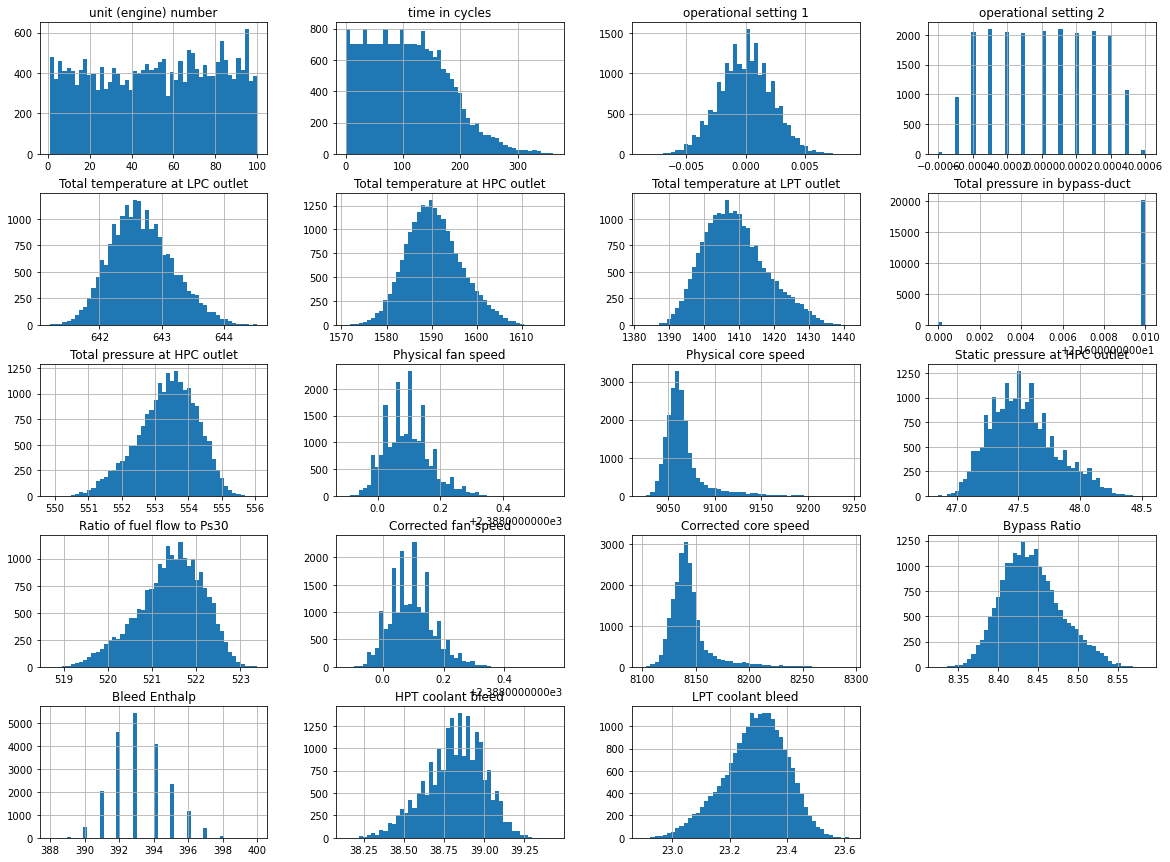

In [426]:
%matplotlib inline
import matplotlib.pyplot as plt
df_train.hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

## Establishing TTF in Cycles

It is now about time to determine the time-to-failure (TTF) for the trainset, for each row.
First, we determine in the trainset for each row the max. cycles for the particular unit. We use the **groupby** command to obtain for every unit the max. number of cycles

In [427]:
df_train.iloc[185:200,0:4]
# Data Frame contains measurements of several sensors for 100 different engines.
# Time in cycles counts the number of measurement cycles until the failure of the engine.

,unit (engine) number,time in cycles,operational setting 1,operational setting 2
185,1,186,0.0027,-0.0003
186,1,187,-0.0047,-0.0000
187,1,188,-0.0067,0.0003
188,1,189,-0.0006,0.0002
189,1,190,-0.0027,0.0001
190,1,191,-0.0000,-0.0004
191,1,192,0.0009,-0.0000
192,2,1,-0.0018,0.0006
193,2,2,0.0043,-0.0003
194,2,3,0.0018,0.0003


In order to determine the Time to Failure (TTF) for each time point and each engine:
(i) the maximimum number of reached cycles per engine is calculated
(ii) for each row, the current cycle number is subtracted from that max number of cycles and
(iii) a dataframe is created, which shows the last running cycle for each engine.

In [428]:
df_max = pd.DataFrame(df_train.groupby('unit (engine) number')['time in cycles'].max())
df_max

,time in cycles
unit (engine) number,
1,192
2,287
3,179
4,189
5,269
...,...
96,336
97,202
98,156


In [429]:
df_train.tail()

,unit (engine) number,time in cycles,operational setting 1,operational setting 2,Total temperature at LPC outlet,Total temperature at HPC outlet,Total temperature at LPT outlet,Total pressure in bypass-duct,Total pressure at HPC outlet,Physical fan speed,Physical core speed,Static pressure at HPC outlet,Ratio of fuel flow to Ps30,Corrected fan speed,Corrected core speed,Bypass Ratio,Bleed Enthalp,HPT coolant bleed,LPT coolant bleed
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640
20630,100,200,-0.0032,-0.0005,643.85,1600.38,1432.14,21.61,550.79,2388.26,9061.48,48.20,519.30,2388.26,8137.33,8.5036,396,38.37,23.0522


In [430]:
df_max.reset_index(level = 0 , inplace=True)
df_max

,unit (engine) number,time in cycles
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


In [431]:
df_max.columns = ['unit (engine) number', 'last_cycle']
df_max

,unit (engine) number,last_cycle
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


Now, we determine the time to failure (TTF) for every row. We subtract the number of cycles from the maximum number of cycles in a particular unit.

\begin{equation*}
\text{TTF}_i = \max(\text{cycles}) - \text{cycles}_i
\end{equation*}

In [432]:
# add max number of cycles per engine as a new column into the training dataset
df_train = pd.merge(df_train, df_max, on = 'unit (engine) number')
df_train

,unit (engine) number,time in cycles,operational setting 1,operational setting 2,Total temperature at LPC outlet,Total temperature at HPC outlet,Total temperature at LPT outlet,Total pressure in bypass-duct,Total pressure at HPC outlet,Physical fan speed,Physical core speed,Static pressure at HPC outlet,Ratio of fuel flow to Ps30,Corrected fan speed,Corrected core speed,Bypass Ratio,Bleed Enthalp,HPT coolant bleed,LPT coolant bleed,last_cycle
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,192
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,192
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,192
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,192
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,200
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,200
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,200
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,200


In [433]:
# add time-to-failure as a new column to the training set
df_train['TTF'] = df_train['last_cycle'] - df_train['time in cycles']
# drop column 'last cycle'
df_train.drop(['last_cycle'], axis = 1, inplace = True)
df_train

,unit (engine) number,time in cycles,operational setting 1,operational setting 2,Total temperature at LPC outlet,Total temperature at HPC outlet,Total temperature at LPT outlet,Total pressure in bypass-duct,Total pressure at HPC outlet,Physical fan speed,Physical core speed,Static pressure at HPC outlet,Ratio of fuel flow to Ps30,Corrected fan speed,Corrected core speed,Bypass Ratio,Bleed Enthalp,HPT coolant bleed,LPT coolant bleed,TTF
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


In [434]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
unit (engine) number,20631.0,51.506568,29.227633,1.0000,26.0000,52.0000,77.0000,100.0000
time in cycles,20631.0,108.807862,68.880990,1.0000,52.0000,104.0000,156.0000,362.0000
operational setting 1,20631.0,-0.000009,0.002187,-0.0087,-0.0015,0.0000,0.0015,0.0087
operational setting 2,20631.0,0.000002,0.000293,-0.0006,-0.0002,0.0000,0.0003,0.0006
Total temperature at LPC outlet,20631.0,642.680934,0.500053,641.2100,642.3250,642.6400,643.0000,644.5300
Total temperature at HPC outlet,20631.0,1590.523119,6.131150,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
Total temperature at LPT outlet,20631.0,1408.933782,9.000605,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
Total pressure in bypass-duct,20631.0,21.609803,0.001389,21.6000,21.6100,21.6100,21.6100,21.6100
Total pressure at HPC outlet,20631.0,553.367711,0.885092,549.8500,552.8100,553.4400,554.0100,556.0600
Physical fan speed,20631.0,2388.096652,0.070985,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600


In [435]:
#take only operational settings and sensor measurements as features
features = df_train.columns.tolist()[2:-1]
features

['operational setting 1',
 'operational setting 2',
 'Total temperature at LPC outlet',
 'Total temperature at HPC outlet',
 'Total temperature at LPT outlet',
 'Total pressure in bypass-duct',
 'Total pressure at HPC outlet',
 'Physical fan speed',
 'Physical core speed',
 'Static pressure at HPC outlet',
 'Ratio of fuel flow to Ps30',
 'Corrected fan speed',
 'Corrected core speed',
 'Bypass Ratio',
 'Bleed Enthalp',
 'HPT coolant bleed',
 'LPT coolant bleed']

In [436]:
#Fitting on the training set 
x_train = df_train.loc[:, features]

#adding back the 'unit (engine) number','time in cycles' and 'TTF' columns
df_train1 = pd.DataFrame(x_train)
df_train1.columns = features
df_train1.insert (0, 'unit (engine) number', df_train["unit (engine) number"])
df_train1.insert (1, 'time in cycles', df_train["time in cycles"])
df_train1.insert (18, 'TTF', df_train['TTF'])

In [437]:
x_test = df_test.loc[:, features].values
df_test1 = pd.DataFrame(x_test)
df_test1.columns = features
df_test1.insert (0, 'unit (engine) number', df_test["unit (engine) number"])
df_test1.insert (1, 'time in cycles', df_test["time in cycles"])

In [438]:
df_train1.describe().T

,count,mean,std,min,25%,50%,75%,max
unit (engine) number,20631.0,51.506568,29.227633,1.0000,26.0000,52.0000,77.0000,100.0000
time in cycles,20631.0,108.807862,68.880990,1.0000,52.0000,104.0000,156.0000,362.0000
operational setting 1,20631.0,-0.000009,0.002187,-0.0087,-0.0015,0.0000,0.0015,0.0087
operational setting 2,20631.0,0.000002,0.000293,-0.0006,-0.0002,0.0000,0.0003,0.0006
Total temperature at LPC outlet,20631.0,642.680934,0.500053,641.2100,642.3250,642.6400,643.0000,644.5300
Total temperature at HPC outlet,20631.0,1590.523119,6.131150,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
Total temperature at LPT outlet,20631.0,1408.933782,9.000605,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
Total pressure in bypass-duct,20631.0,21.609803,0.001389,21.6000,21.6100,21.6100,21.6100,21.6100
Total pressure at HPC outlet,20631.0,553.367711,0.885092,549.8500,552.8100,553.4400,554.0100,556.0600
Physical fan speed,20631.0,2388.096652,0.070985,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600


In [439]:
df_test1.describe().T

,count,mean,std,min,25%,50%,75%,max
unit (engine) number,13096.0,51.543907,28.289423,1.0000,28.0000,52.0000,76.0000,100.0000
time in cycles,13096.0,76.836515,53.057749,1.0000,33.0000,69.0000,113.0000,303.0000
operational setting 1,13096.0,-0.000011,0.002203,-0.0082,-0.0015,0.0000,0.0015,0.0078
operational setting 2,13096.0,0.000004,0.000294,-0.0006,-0.0002,0.0000,0.0003,0.0007
Total temperature at LPC outlet,13096.0,642.475088,0.400899,641.1300,642.1975,642.4600,642.7400,644.3000
Total temperature at HPC outlet,13096.0,1588.099204,5.003274,1569.0400,1584.6000,1587.9900,1591.3625,1607.5500
Total temperature at LPT outlet,13096.0,1404.735362,6.688309,1384.3900,1399.9500,1404.4400,1409.0500,1433.3600
Total pressure in bypass-duct,13096.0,21.609701,0.001704,21.6000,21.6100,21.6100,21.6100,21.6100
Total pressure at HPC outlet,13096.0,553.757523,0.681286,550.8800,553.3100,553.8000,554.2400,555.8400
Physical fan speed,13096.0,2388.070964,0.057442,2387.8900,2388.0300,2388.0700,2388.1100,2388.3000


In [440]:
#Merging the true TTF values with the test dataset

df_pr = pd.DataFrame(columns=features)
#We select the last entery for each unit in the test set then we append to it its corresponding True TTF value from TrueTTF
a=0
for i in range(0,len(df_test1)):
    if (df_test1['unit (engine) number'].values[i] != a):
            df_pr=df_pr.append(df_test1.iloc[i-1])
            a=a+1
df_test2 = df_pr.sort_values('unit (engine) number', axis=0, ascending=True).reset_index(drop=True)
df_test2

,operational setting 1,operational setting 2,Total temperature at LPC outlet,Total temperature at HPC outlet,Total temperature at LPT outlet,Total pressure in bypass-duct,Total pressure at HPC outlet,Physical fan speed,Physical core speed,Static pressure at HPC outlet,Ratio of fuel flow to Ps30,Corrected fan speed,Corrected core speed,Bypass Ratio,Bleed Enthalp,HPT coolant bleed,LPT coolant bleed,time in cycles,unit (engine) number
0,-0.0006,0.0004,642.58,1581.22,1398.91,21.61,554.42,2388.08,9056.40,47.23,521.79,2388.06,8130.11,8.4024,393.0,38.81,23.3552,31.0,1.0
1,0.0018,-0.0001,642.55,1586.59,1410.83,21.61,553.52,2388.10,9044.77,47.67,521.74,2388.09,8126.90,8.4505,391.0,38.81,23.2618,49.0,2.0
2,-0.0016,0.0004,642.88,1589.75,1418.89,21.61,552.59,2388.16,9049.26,47.88,520.83,2388.14,8131.46,8.4119,395.0,38.93,23.2740,126.0,3.0
3,0.0012,0.0004,642.78,1594.53,1406.88,21.61,552.64,2388.13,9051.30,47.65,521.88,2388.11,8133.64,8.4634,395.0,38.58,23.2581,106.0,4.0
4,-0.0013,-0.0004,642.27,1589.94,1419.36,21.61,553.29,2388.10,9053.99,47.46,521.00,2388.15,8125.74,8.4362,394.0,38.75,23.4117,98.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.0006,0.0003,642.30,1590.88,1397.94,21.61,553.99,2388.03,9062.41,47.14,522.30,2388.01,8148.24,8.4110,391.0,38.96,23.4606,97.0,96.0
96,0.0013,-0.0001,642.59,1582.96,1410.92,21.61,554.05,2388.06,9076.36,47.38,521.58,2388.06,8155.48,8.4500,395.0,38.61,23.2953,134.0,97.0
97,0.0017,0.0001,642.68,1599.51,1415.47,21.61,553.44,2388.13,9062.34,47.66,521.53,2388.09,8146.39,8.4235,394.0,38.76,23.3608,121.0,98.0
98,0.0047,-0.0000,642.00,1585.03,1397.98,21.61,554.75,2388.01,9067.16,47.26,521.82,2388.02,8150.38,8.4003,391.0,38.95,23.3595,97.0,99.0


In [441]:
X_train = df_train1[features] 
X_test = df_test2[features]
y_train = df_train1[['TTF']] 
y_test = TrueTTF[['TTF']]

In [442]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (20631, 17)
Training Labels Shape: (20631, 1)
Testing Features Shape: (100, 17)
Testing Labels Shape: (100, 1)


In [443]:
X_test

,operational setting 1,operational setting 2,Total temperature at LPC outlet,Total temperature at HPC outlet,Total temperature at LPT outlet,Total pressure in bypass-duct,Total pressure at HPC outlet,Physical fan speed,Physical core speed,Static pressure at HPC outlet,Ratio of fuel flow to Ps30,Corrected fan speed,Corrected core speed,Bypass Ratio,Bleed Enthalp,HPT coolant bleed,LPT coolant bleed
0,-0.0006,0.0004,642.58,1581.22,1398.91,21.61,554.42,2388.08,9056.40,47.23,521.79,2388.06,8130.11,8.4024,393.0,38.81,23.3552
1,0.0018,-0.0001,642.55,1586.59,1410.83,21.61,553.52,2388.10,9044.77,47.67,521.74,2388.09,8126.90,8.4505,391.0,38.81,23.2618
2,-0.0016,0.0004,642.88,1589.75,1418.89,21.61,552.59,2388.16,9049.26,47.88,520.83,2388.14,8131.46,8.4119,395.0,38.93,23.2740
3,0.0012,0.0004,642.78,1594.53,1406.88,21.61,552.64,2388.13,9051.30,47.65,521.88,2388.11,8133.64,8.4634,395.0,38.58,23.2581
4,-0.0013,-0.0004,642.27,1589.94,1419.36,21.61,553.29,2388.10,9053.99,47.46,521.00,2388.15,8125.74,8.4362,394.0,38.75,23.4117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.0006,0.0003,642.30,1590.88,1397.94,21.61,553.99,2388.03,9062.41,47.14,522.30,2388.01,8148.24,8.4110,391.0,38.96,23.4606
96,0.0013,-0.0001,642.59,1582.96,1410.92,21.61,554.05,2388.06,9076.36,47.38,521.58,2388.06,8155.48,8.4500,395.0,38.61,23.2953
97,0.0017,0.0001,642.68,1599.51,1415.47,21.61,553.44,2388.13,9062.34,47.66,521.53,2388.09,8146.39,8.4235,394.0,38.76,23.3608
98,0.0047,-0.0000,642.00,1585.03,1397.98,21.61,554.75,2388.01,9067.16,47.26,521.82,2388.02,8150.38,8.4003,391.0,38.95,23.3595


# Train and evaluate a Linear Regression model

In [444]:
# Choose model class and hyperparameters
model_lr = LinearRegression()
# Fit model
model_lr.fit(X_train, y_train)
# predict values of the test dataset
y_pred_lr = model_lr.predict(X_test)
# calculate mean squared error
mse_lr = mean_squared_error(y_pred_lr, y_test)
# calculate root mean squared error
rmse_lr = np.sqrt(mse_lr)
# print result
print('Linear Regression RMSE: ', '{:,}'.format(round(rmse_lr, 2)))

Linear Regression RMSE:  32.04


# Train and evaluate a Random Forest model

In [445]:
# Choose model class and hyperparameters
model_rf = RandomForestRegressor(random_state=42,n_estimators=40)
# Fit model
model_rf.fit(X_train, y_train)
# predict values of the test dataset
y_pred_rf = model_rf.predict(X_test)
# calculate mean squared error
mse_rf = mean_squared_error(y_pred_rf, y_test)
# calculate root mean squared error
rmse_rf = np.sqrt(mse_rf)
# print result
print('Random Forest RMSE: ', '{:,}'.format(round(rmse_rf, 2)))

C:\Users\Mirko\AppData\Local\Temp/ipykernel_9516/2598356896.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf.fit(X_train, y_train)


Random Forest RMSE:  33.89


# Train and evaluate a Gradient Boosting model

In [446]:
# Choose model class and hyperparameters
model_gb = ensemble.GradientBoostingRegressor()
# Fit model
model_gb.fit(X_train, y_train)
# predict values of the test dataset
y_pred_gb = model_gb.predict(X_test)
# calculate mean squared error
mse_gb = mean_squared_error(y_pred_gb, y_test)
# calculate root mean squared error
rmse_gb = np.sqrt(mse_gb)
# print result
print('Gradient Boosting RMSE: ', '{:,}'.format(round(rmse_gb, 2)))

C:\Users\Mirko\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Gradient Boosting RMSE:  32.6


# Choosing The best Model

In [447]:
df_Summary = pd.DataFrame({'RMSE': [rmse_lr, rmse_rf, rmse_gb]},
                  index=['Linear Regression', 'Random Forest Regressor', 'Gradient Boosting Regressor'])
df_Summary

,RMSE
Linear Regression,32.041095
Random Forest Regressor,33.894097
Gradient Boosting Regressor,32.597471


# Prediction

In [449]:
print(X_train.columns)

Index(['operational setting 1', 'operational setting 2',
       'Total temperature at LPC outlet', 'Total temperature at HPC outlet',
       'Total temperature at LPT outlet', 'Total pressure in bypass-duct',
       'Total pressure at HPC outlet', 'Physical fan speed',
       'Physical core speed', 'Static pressure at HPC outlet',
       'Ratio of fuel flow to Ps30', 'Corrected fan speed',
       'Corrected core speed', 'Bypass Ratio', 'Bleed Enthalp',
       'HPT coolant bleed', 'LPT coolant bleed'],
      dtype='object')


In [450]:
#a = float(input("Please enter the Total temperature at LPC outlet:"))
#b = float(input("Please enter the Total temperature at HPC outlet:"))
#c = float(input("Please enter the Total temperature at LPT outlet:"))
#d = float(input("Please enter the Total pressure at HPC outlet:"))
#e = float(input("Please enter the Physical core speed:"))
#f = float(input("Please enter the Static pressure at HPC outlet:"))
#g = float(input("Please enter the Ratio of fuel flow to Ps30:"))
#h = float(input("Please enter the Corrected core speed:"))
#i = float(input("Please enter the Bypass Ratio:"))
#j = float(input("Please enter the Bleed Enthalp:"))
#k = float(input("Please enter the HPT coolant bleed:"))
#l = float(input("Please enter the LPT coolant bleed:"))
#new_data = np.array([a,b,c,d,e,f,g,h,i,j,k,l]).reshape(1,-1)
new_data = np.array(X_test.iloc[1,:]).reshape(1,-1)
new_pred=regressor.predict(new_data)
result = float(new_pred[0])
print(X_test.iloc[1,:])
print("The linear regression model predicts that the Time-to-failure for the part of the engine is : " ,round(result,2))

operational setting 1                 0.0018
operational setting 2                -0.0001
Total temperature at LPC outlet     642.5500
Total temperature at HPC outlet    1586.5900
Total temperature at LPT outlet    1410.8300
Total pressure in bypass-duct        21.6100
Total pressure at HPC outlet        553.5200
Physical fan speed                 2388.1000
Physical core speed                9044.7700
Static pressure at HPC outlet        47.6700
Ratio of fuel flow to Ps30          521.7400
Corrected fan speed                2388.0900
Corrected core speed               8126.9000
Bypass Ratio                          8.4505
Bleed Enthalp                       391.0000
HPT coolant bleed                    38.8100
LPT coolant bleed                    23.2618
Name: 1, dtype: float64
The linear regression model predicts that the Time-to-failure for the part of the engine is :  122.16


# Improving model performance by adding and selecting features

Including the current cycle number and performing a feature selection of only features correlating with the time to failure

In [451]:
corr_matrix = df_train1.corr()
# Find correlations of all columns with TTF column and order by amount
corr_matrix["TTF"].sort_values(ascending=False)

TTF                                1.000000
Ratio of fuel flow to Ps30         0.671983
Total pressure at HPC outlet       0.657223
LPT coolant bleed                  0.635662
HPT coolant bleed                  0.629428
unit (engine) number               0.078753
operational setting 2             -0.001948
operational setting 1             -0.003198
Total pressure in bypass-duct     -0.128348
Corrected core speed              -0.306769
Physical core speed               -0.390102
Corrected fan speed               -0.562569
Physical fan speed                -0.563968
Total temperature at HPC outlet   -0.584520
Bleed Enthalp                     -0.606154
Total temperature at LPC outlet   -0.606484
Bypass Ratio                      -0.642667
Total temperature at LPT outlet   -0.678948
Static pressure at HPC outlet     -0.696228
time in cycles                    -0.736241
Name: TTF, dtype: float64

In [452]:
# absolute values of correlation with TTF unordered
corr_matrix["TTF"].abs()

unit (engine) number               0.078753
time in cycles                     0.736241
operational setting 1              0.003198
operational setting 2              0.001948
Total temperature at LPC outlet    0.606484
Total temperature at HPC outlet    0.584520
Total temperature at LPT outlet    0.678948
Total pressure in bypass-duct      0.128348
Total pressure at HPC outlet       0.657223
Physical fan speed                 0.563968
Physical core speed                0.390102
Static pressure at HPC outlet      0.696228
Ratio of fuel flow to Ps30         0.671983
Corrected fan speed                0.562569
Corrected core speed               0.306769
Bypass Ratio                       0.642667
Bleed Enthalp                      0.606154
HPT coolant bleed                  0.629428
TTF                                1.000000
LPT coolant bleed                  0.635662
Name: TTF, dtype: float64

In [453]:
#Find columns with a low absolute value of correlation with the TTF
low_corr=np.where(corr_matrix["TTF"].abs()<0.1)
low_corr

(array([0, 2, 3], dtype=int64),)

In [454]:
drop_cols=df_train1.columns[low_corr].tolist()
drop_cols.append('TTF')
drop_cols

['unit (engine) number',
 'operational setting 1',
 'operational setting 2',
 'TTF']

In [455]:
X_train2 = df_train1.drop(drop_cols,axis = 1)
X_train2.columns

Index(['time in cycles', 'Total temperature at LPC outlet',
       'Total temperature at HPC outlet', 'Total temperature at LPT outlet',
       'Total pressure in bypass-duct', 'Total pressure at HPC outlet',
       'Physical fan speed', 'Physical core speed',
       'Static pressure at HPC outlet', 'Ratio of fuel flow to Ps30',
       'Corrected fan speed', 'Corrected core speed', 'Bypass Ratio',
       'Bleed Enthalp', 'HPT coolant bleed', 'LPT coolant bleed'],
      dtype='object')

In [456]:
X_test2 = df_test2[X_train2.columns]
X_test2

,time in cycles,Total temperature at LPC outlet,Total temperature at HPC outlet,Total temperature at LPT outlet,Total pressure in bypass-duct,Total pressure at HPC outlet,Physical fan speed,Physical core speed,Static pressure at HPC outlet,Ratio of fuel flow to Ps30,Corrected fan speed,Corrected core speed,Bypass Ratio,Bleed Enthalp,HPT coolant bleed,LPT coolant bleed
0,31.0,642.58,1581.22,1398.91,21.61,554.42,2388.08,9056.40,47.23,521.79,2388.06,8130.11,8.4024,393.0,38.81,23.3552
1,49.0,642.55,1586.59,1410.83,21.61,553.52,2388.10,9044.77,47.67,521.74,2388.09,8126.90,8.4505,391.0,38.81,23.2618
2,126.0,642.88,1589.75,1418.89,21.61,552.59,2388.16,9049.26,47.88,520.83,2388.14,8131.46,8.4119,395.0,38.93,23.2740
3,106.0,642.78,1594.53,1406.88,21.61,552.64,2388.13,9051.30,47.65,521.88,2388.11,8133.64,8.4634,395.0,38.58,23.2581
4,98.0,642.27,1589.94,1419.36,21.61,553.29,2388.10,9053.99,47.46,521.00,2388.15,8125.74,8.4362,394.0,38.75,23.4117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,97.0,642.30,1590.88,1397.94,21.61,553.99,2388.03,9062.41,47.14,522.30,2388.01,8148.24,8.4110,391.0,38.96,23.4606
96,134.0,642.59,1582.96,1410.92,21.61,554.05,2388.06,9076.36,47.38,521.58,2388.06,8155.48,8.4500,395.0,38.61,23.2953
97,121.0,642.68,1599.51,1415.47,21.61,553.44,2388.13,9062.34,47.66,521.53,2388.09,8146.39,8.4235,394.0,38.76,23.3608
98,97.0,642.00,1585.03,1397.98,21.61,554.75,2388.01,9067.16,47.26,521.82,2388.02,8150.38,8.4003,391.0,38.95,23.3595


In [461]:
print('Training Features Shape:', X_train2.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test2.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (20631, 16)
Training Labels Shape: (20631, 1)
Testing Features Shape: (100, 16)
Testing Labels Shape: (100, 1)


# Train and evaluate a second Linear Regression model

In [457]:
# Choose model class and hyperparameters
model_lr2 = LinearRegression()
# Fit model
model_lr2.fit(X_train2, y_train)
# predict values of the test dataset
y_pred_lr2 = model_lr2.predict(X_test2)
# calculate mean squared error
mse_lr2 = mean_squared_error(y_pred_lr2, y_test)
# calculate root mean squared error
rmse_lr2 = np.sqrt(mse_lr2)
# print result
print('Linear Regression 2 RMSE: ', '{:,}'.format(round(rmse_lr2, 2)))

Linear Regression 2 RMSE:  31.13


# Train and evaluate a Random Forest model

In [458]:
# Choose model class and hyperparameters
model_rf2 = RandomForestRegressor(random_state=42,n_estimators=40)
# Fit model
model_rf2.fit(X_train2, y_train)
# predict values of the test dataset
y_pred_rf2 = model_rf2.predict(X_test2)
# calculate mean squared error
mse_rf2 = mean_squared_error(y_pred_rf2, y_test)
# calculate root mean squared error
rmse_rf2 = np.sqrt(mse_rf2)
# print result
print('Random Forest 2 RMSE: ', '{:,}'.format(round(rmse_rf2, 2)))

C:\Users\Mirko\AppData\Local\Temp/ipykernel_9516/2283321228.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf2.fit(X_train2, y_train)


Random Forest 2 RMSE:  27.71


# Train and evaluate a Gradient Boosting model

In [459]:
# Choose model class and hyperparameters
model_gb2 = ensemble.GradientBoostingRegressor()
# Fit model
model_gb2.fit(X_train2, y_train)
# predict values of the test dataset
y_pred_gb2 = model_gb2.predict(X_test2)
# calculate mean squared error
mse_gb2 = mean_squared_error(y_pred_gb2, y_test)
# calculate root mean squared error
rmse_gb2 = np.sqrt(mse_gb2)
# print result
print('Gradient Boosting 2 RMSE: ', '{:,}'.format(round(rmse_gb2, 2)))

C:\Users\Mirko\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Gradient Boosting 2 RMSE:  24.87


# Choosing The best Model

In [462]:
df_Summary = pd.DataFrame({'RMSE': [rmse_lr, rmse_rf, rmse_gb, rmse_lr2, rmse_rf2, rmse_gb2]},
                  index=['Linear Regression', 'Random Forest Regressor', 'Gradient Boosting Regressor', 'Linear Regression 2', 'Random Forest Regressor 2', 'Gradient Boosting Regressor 2'])
df_Summary

,RMSE
Linear Regression,32.041095
Random Forest Regressor,33.894097
Gradient Boosting Regressor,32.597471
Linear Regression 2,31.133361
Random Forest Regressor 2,27.707551
Gradient Boosting Regressor 2,24.868571


In [463]:
df_Summary['RMSE'].min()

24.8685710456016